In [1]:
import mailbox
from datetime import datetime
from datetime import timedelta
import re

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.style.use('ggplot')

In [2]:
# compiled regex for getting date sent from email dump
match = re.compile('Date: .*')

# extract the initial send date from the message body
def parse_date(message):
    date_string = re.findall(match, message)[0].split(', ',1)[1]
    date_time = datetime.strptime(date_string,'%b %d, %Y at %I:%M %p')
    return date_time

# create a new column of timedeltas between rows
def create_timedelta(df):
    df = df.sort_values('date')
    df['timedelta'] = df['date'].subtract(df['date'].shift(1))
    return df[1:-1]

def create_email_df(mbox_path):
    # load emails from file
    mbox = mailbox.mbox(mbox_path)
    
    # iterate through email dump and extract all send dates
    date_list = []

    for m in mbox:
        body = m.get_payload(0).as_string()
        date = parse_date(body)
        date_list.append(date)
        
    # create a dataframe with timedeltas
    df = pd.DataFrame({'date':date_list})
    df = create_timedelta(df)

    return df

In [3]:
# load all data
email_df = create_email_df('/srv/zooniverse/raw_data/emails/zooniverse.mbox')
classification_df = pd.read_csv('/srv/zooniverse/tables/all_classifications_table_02-18-19.csv')
project_df = pd.read_csv('/srv/zooniverse/tables/all_projects_table_02-18-19.csv')

/home/sjm668/dev/zooniverse/src/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# only use "official" projects and classifications
classification_df = classification_df.loc[classification_df['panoptes_api_official_project'] == 1]
project_df = project_df.loc[(project_df['panoptes_api_official_project'] == 1)]

# only include projects that also have classification data
project_df = project_df.loc[((project_df['panoptes_api'] == 1) & (project_df['ouroboros_dump'] == 1)) | (project_df['panoptes_dump'] == 1) & (project_df['panoptes_api'] == 1)]

# convert classification timestamp to datetime
classification_df['created_at'] = pd.to_datetime(classification_df['created_at'])

In [6]:
# add iso_week column
def get_weeks(x):
    return x.isocalendar()[0]*52+x.isocalendar()[1]

classification_df['iso_week'] = classification_df['created_at'].apply(get_weeks)

In [8]:
# remove all ouroboros classifications
classification_df = classification_df.loc[classification_df['panoptes_dump'] == 1]

In [28]:
def classifications_by_week_hist(classification_df,bin_size=1000):
    classifications_by_week = classification_df.groupby(['panoptes_project_id','iso_week'])['iso_week'].size().to_frame('classifications')
    classifications_by_week.hist(figsize=(12,12),bins=np.arange(0,classifications_by_week['classifications'].max(),bin_size))
    plt.xlabel('Number of Classifications')
    plt.ylabel('Number of Project-Weeks with X Classifications')
    plt.tight_layout()
    plt.title('Distribution of Classifications per Project-Week.  Bin size = {0}'.format(bin_size))
    

# Distribution of Classifications per Project-Week.  Bin size = 1000

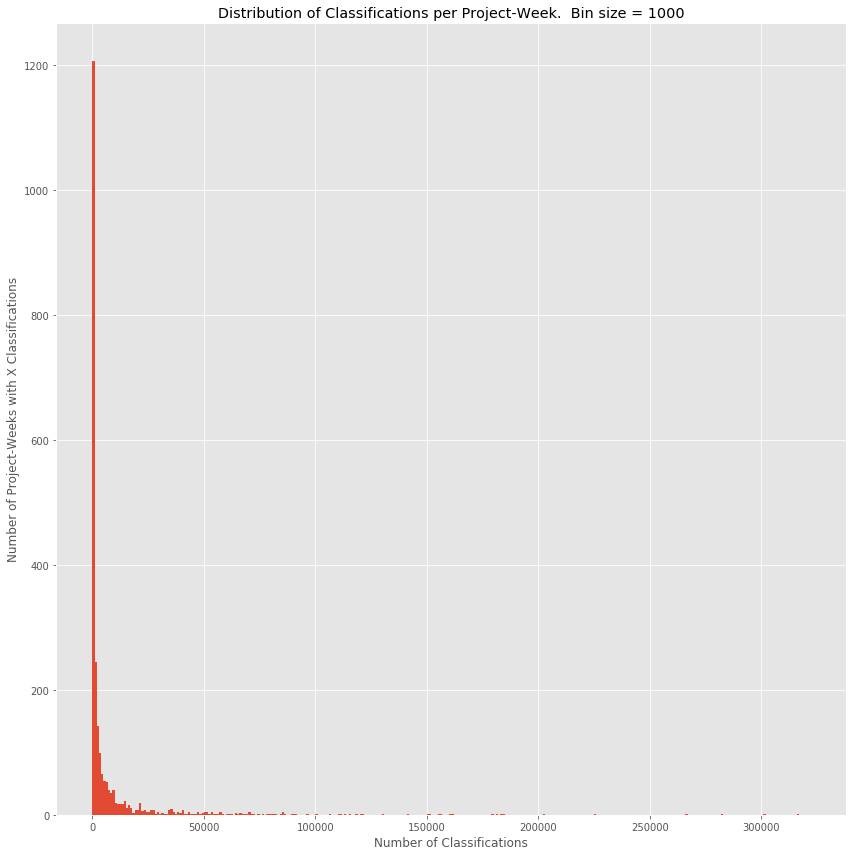

In [29]:
classifications_by_week_hist(classification_df=classification_df)

# Unregistered Account Summary Stats

In [33]:
print('Number of Unregistered Classifications: {0}'.format(len(classification_df.loc[classification_df['user_id'].isnull()])))
print('Percentage of Unregistered Classifications: {0}'.format((len(classification_df.loc[classification_df['user_id'].isnull()]))/len(classification_df)))

Number of Unregistered Classifications: 3694903
Percentage of Unregistered Classifications: 0.19547713809724596


# Summary and Distribution of Classifications per Volunteer-Project-Week

In [50]:
print('Distribution of Classifications per Volunteer-Project-Week\n')
print(classification_df.loc[classification_df['user_id'].notnull()].groupby(['user_id','panoptes_project_id','iso_week'])['iso_week'].size().describe())

Distribution of Classifications per Volunteer-Project-Week

count    212092.000000
mean         71.700333
std         272.182123
min           1.000000
25%           4.000000
50%          14.000000
75%          46.000000
max       20932.000000
dtype: float64


In [40]:
def classifications_by_volunteer_by_week_hist(classification_df,bin_size=10):
    classifications_by_week = classification_df.groupby(['panoptes_project_id','user_id','iso_week'])['iso_week'].size().to_frame('classifications')
    classifications_by_week.hist(figsize=(12,12),bins=np.arange(0,classifications_by_week['classifications'].max(),bin_size))
    plt.xlabel('Number of Classifications')
    plt.ylabel('Number of Volunteer-Project-Weeks with X Classifications')
    plt.tight_layout()
    plt.title('Distribution of Classifications per Volunteer-Project-Week.  Bin size = {0}'.format(bin_size))

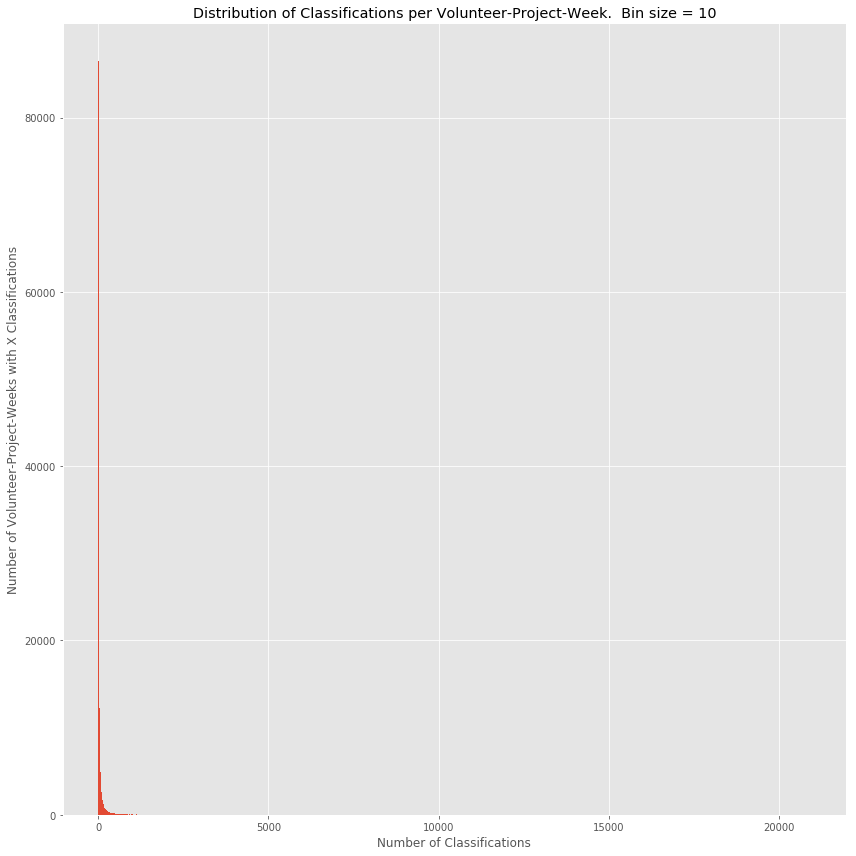

In [41]:
classifications_by_volunteer_by_week_hist(classification_df=classification_df.loc[classification_df['user_id'].notnull()])

# Number of Projects Contributed to Per Volunteer

In [51]:
print('Number of Projects per Volunteer\n')
print(classification_df.loc[classification_df['user_id'].notnull()].groupby('user_id')['panoptes_project_id'].nunique().describe())

Number of Projects per Volunteer

count    69811.000000
mean         1.941428
std          2.299018
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         46.000000
Name: panoptes_project_id, dtype: float64


In [52]:
print('Number of Projects per Volunteer-Week\n')
print(classification_df.loc[classification_df['user_id'].notnull()].groupby(['user_id','iso_week'])['panoptes_project_id'].nunique().describe())

Number of Projects per Volunteer-Week

count    156656.000000
mean          1.353871
std           0.912748
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          22.000000
Name: panoptes_project_id, dtype: float64


In [53]:
print('Projects per Volunteer-Week Percentiles\n')
classification_df.loc[classification_df['user_id'].notnull()].groupby(['user_id','iso_week'])['panoptes_project_id'].nunique().quantile(np.arange(0,1,.1))

Projects per Volunteer-Week Percentiles



0.0    1.0
0.1    1.0
0.2    1.0
0.3    1.0
0.4    1.0
0.5    1.0
0.6    1.0
0.7    1.0
0.8    2.0
0.9    2.0
Name: panoptes_project_id, dtype: float64